### Importing the libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For data processing
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer,MinMaxScaler

# For model training and evaluation
from pycaret.classification import setup, compare_models, evaluate_model, predict_model, save_model, load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("Everything imported succesfully !")

Everything imported succesfully !


In [2]:
# Reading the data from the csv file 
df = pd.read_csv('diabetes.csv')

### Exploratory data analysis

In [3]:
# Let's check the shape of the dataset
print("The shape of the dataframe :",df.shape)

The shape of the dataframe : (768, 9)


In [4]:
# Let's take look at 5 random rows from the dataset
df.sample(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
300,0,167,0,0,0,32.3,0.839,30,1
548,1,164,82,43,67,32.8,0.341,50,0
699,4,118,70,0,0,44.5,0.904,26,0
302,5,77,82,41,42,35.8,0.156,35,0
468,8,120,0,0,0,30.0,0.183,38,1


In [5]:
# Let's get some basic information about our data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB



- All the features in our dataset are numerical features.
- We can reduce the memory usage we can use float32 and int32 datatypes
- There are no missing values present

In [6]:
int_cols = df.select_dtypes(include = np.int64)
float_cols = df.select_dtypes(include = np.float64)

# Changing the datatype from 64 bit to 32 bit
df[int_cols.columns] = df[int_cols.columns].astype(np.int32)
df[float_cols.columns] = df[float_cols.columns].astype(np.float32)

In [7]:
# Let's check if there are any duplicate values
print("Total duplicate values : ",df.duplicated().sum())

Total duplicate values :  0


In [8]:
# Let's get a descriptive information
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992579,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884161,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.299999,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.599998,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.099998,2.420000,81.000000,1.000000


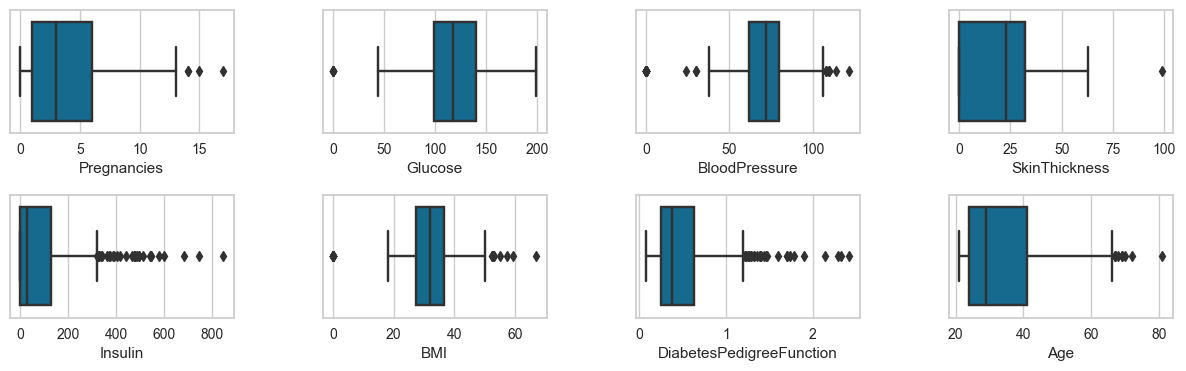

In [9]:
# Let's check if there are any outliers 
fig,ax = plt.subplots(2,4,figsize = (15,4))

sns.boxplot(x = df['Pregnancies'],ax = ax[0][0])
sns.boxplot(x = df['Glucose'],ax = ax[0][1])
sns.boxplot(x = df['BloodPressure'],ax = ax[0][2])
sns.boxplot(x = df['SkinThickness'],ax = ax[0][3])

sns.boxplot(x = df['Insulin'],ax = ax[1][0])
sns.boxplot(x = df['BMI'],ax = ax[1][1])
sns.boxplot(x = df['DiabetesPedigreeFunction'],ax = ax[1][2])
sns.boxplot(x = df['Age'],ax = ax[1][3])

plt.subplots_adjust(hspace = 0.5,wspace = 0.4)
plt.show()

### Data processing using pipeline

**For dealing with outliers**

Since out dataset is small thus, first instead of simply removing or capping the outliers we will transform the data using the Yeo-Johnson transformation and will train our model after that we will check if we need to remove or cap the outliers.

**For normalizing the values**
We will be using something

In [14]:
# Column transformer for dealing with outliers
yeo_transformation = ColumnTransformer(transformers = [
    ('Yeo-Johnson',PowerTransformer(),[0,1,2,3,4,5,6,7])
],remainder = 'passthrough')

# Column transformer to do feature scaling
scaling_transformer = ColumnTransformer(transformers=[
    ('scale_transformer', MinMaxScaler(), [0,1,2,3,4,5,6,7])
], remainder='passthrough')

# Let's build a pipeline
pipe = Pipeline(steps = [
    #('Yeo-Johnson-Transformation', yeo_transformation),
    ('Scaling', scaling_transformer),
])

In [15]:
# Seperating the data into dependent and independent variables
X = df[df.columns[:-1]].values
y = df[df.columns[-1]].values

# Let's do train test and validation split ( 70 : 15 : 15 )
X_train,X_test_val,y_train,y_test_val = train_test_split(X,y,test_size=0.3,random_state = 0)
X_val,X_test,y_val,y_test = train_test_split(X_test_val,y_test_val,test_size=0.5,random_state = 0)

In [16]:
# Let's pass the training data throug the pipeline
X_train = pipe.fit_transform(X_train)

### Model building

In [17]:
# Intializing the setup with preprocessing
clf = setup(X_train, target=y_train,preprocess= False,use_gpu=True)

# compare selected models
best_model = compare_models(include= ['lr', 'knn', 'nb', 'dt', 'svm', 'rbfsvm', 'gpc', 'mlp', 'ridge',
       'rf', 'qda', 'ada', 'gbc', 'lda', 'et', 'lightgbm', 'dummy'])

,Description,Value
0,Session id,1218
1,Target,target
2,Target type,Binary
3,Original data shape,"(537, 9)"
4,Transformed data shape,"(537, 9)"
5,Transformed train set shape,"(375, 9)"
6,Transformed test set shape,"(162, 9)"
7,Numeric features,8


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.7626,0.8047,0.6000,0.7044,0.6422,0.4675,0.4751,1.0600
lda,Linear Discriminant Analysis,0.7573,0.8188,0.5698,0.7027,0.6250,0.4495,0.4574,0.1750
mlp,MLP Classifier,0.7520,0.8246,0.5841,0.6827,0.6278,0.4436,0.4480,2.3730
et,Extra Trees Classifier,0.7496,0.7967,0.5626,0.6961,0.6126,0.4325,0.4442,0.9730
nb,Naive Bayes,0.7493,0.8105,0.6148,0.6633,0.6321,0.4438,0.4492,0.1150
ridge,Ridge Classifier,0.7466,0.0000,0.5401,0.6905,0.6021,0.4214,0.4305,0.1230
gpc,Gaussian Process Classifier,0.7413,0.8160,0.4885,0.7108,0.5743,0.3982,0.4154,0.7150
lightgbm,Light Gradient Boosting Machine,0.7413,0.7693,0.6000,0.6600,0.6233,0.4283,0.4330,0.9350
gbc,Gradient Boosting Classifier,0.7359,0.7953,0.5846,0.6567,0.6150,0.4157,0.4196,0.6000
lr,Logistic Regression,0.7358,0.8123,0.4659,0.7028,0.5551,0.3801,0.3984,0.1170
